In [1]:
from datetime import datetime
from ecallisto_ng.plotting.plotting import plot_spectogram_mpl, fill_missing_timesteps_with_nan
from ecallisto_ng.combine_antennas.combine import preprocess_data, sync_spectrograms, match_spectrograms
import pandas as pd
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from ecallisto_ng.plotting.utils import (
    fill_missing_timesteps_with_nan,
)
from glob import glob
import torch
import pandas as pd
from typing import List

In [2]:
start_datetime = datetime(2023, 9, 8, 0, 0, 0).strftime("%Y-%m-%d %H:%M:%S")
end_datetime = datetime(2023, 9, 8, 23, 59, 59).strftime("%Y-%m-%d %H:%M:%S")
data_folder = 'data_3'
filter = None
location = ['swiss', 'germany', 'austria', 'glasgow', 'egypt', 'ethiopia', 'denmark', 'spain', 'triest', 'krim']

In [3]:
files = glob(f"{data_folder}/*.parquet")

In [4]:
datas = [pd.read_parquet(file) for file in files] #if any(loc in file for loc in location)]

In [5]:
# Process data
data_processed = preprocess_data(datas)

/home/kenfus/miniconda3/envs/ecallisto_virtual_antenna/lib/python3.11/site-packages/ecallisto_ng/plotting/plotting.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=fig_size)


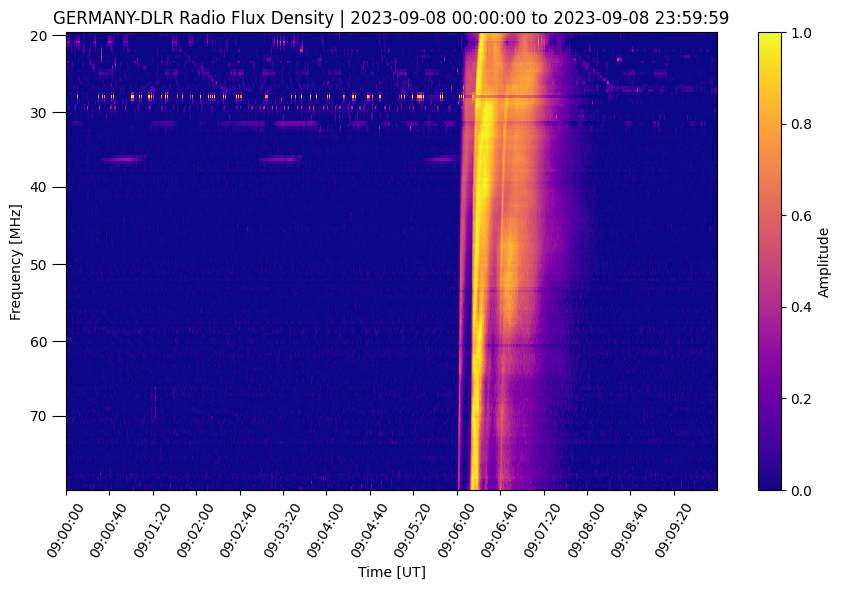

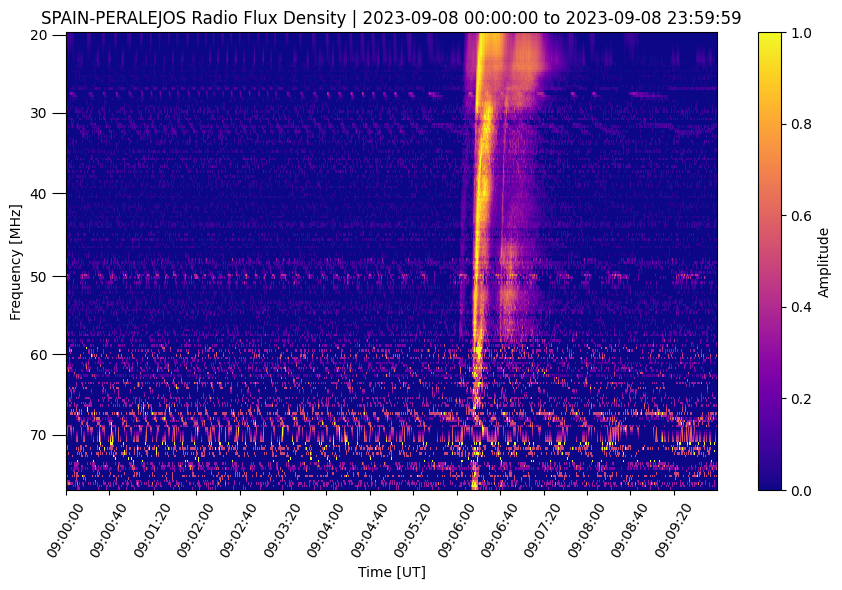

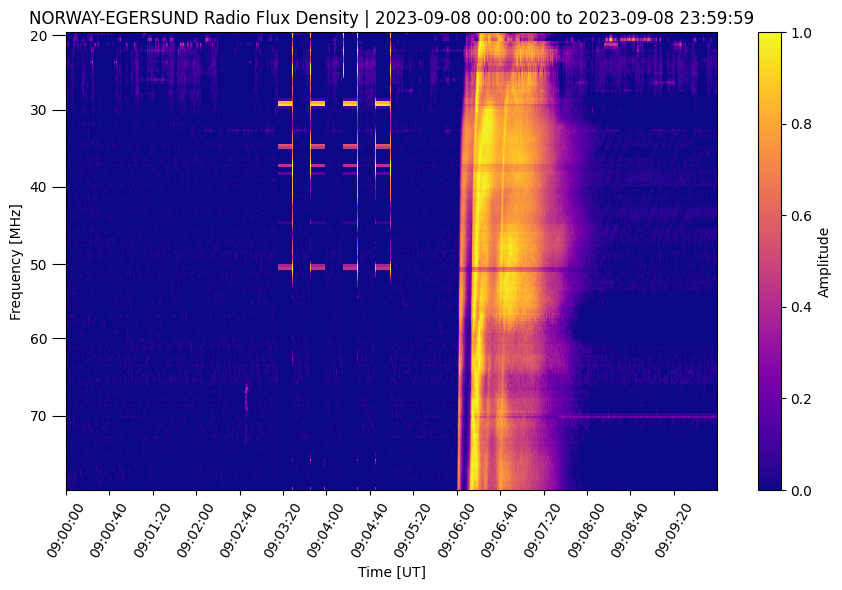

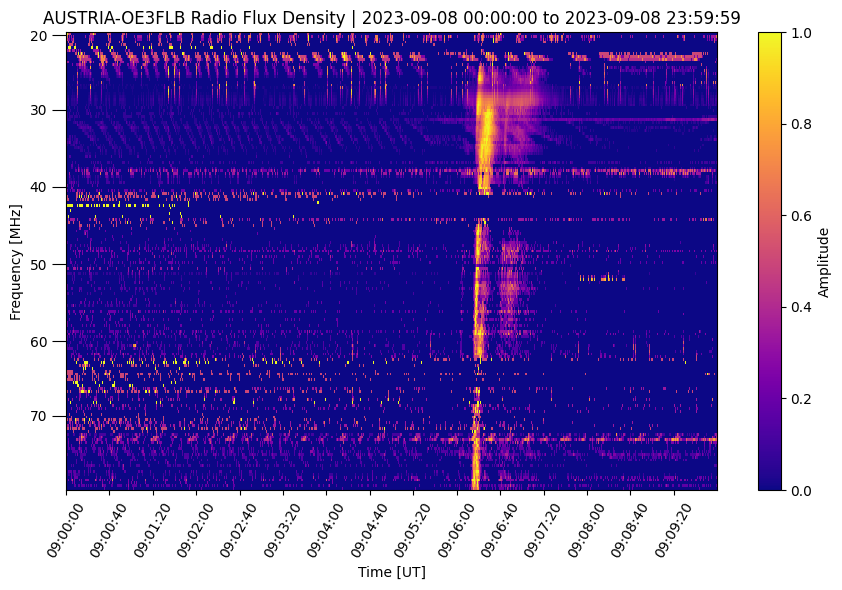

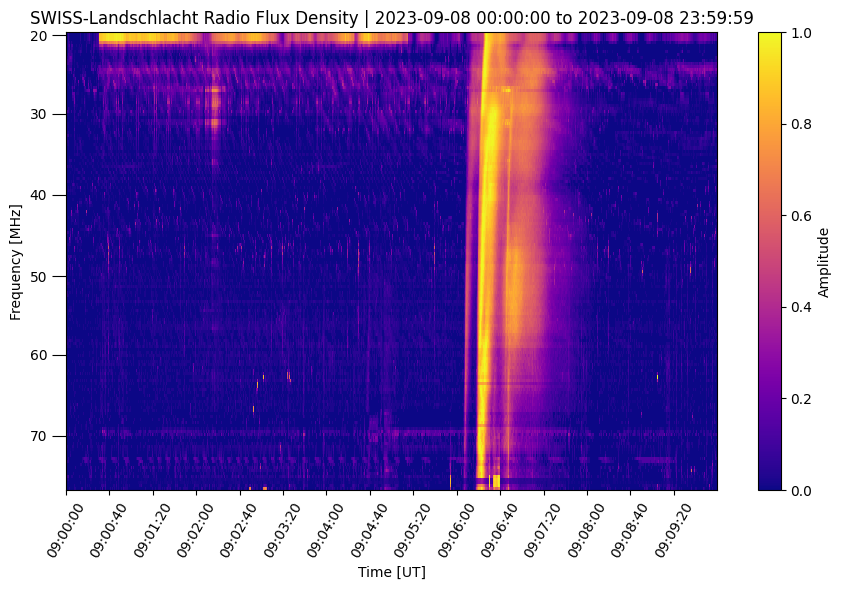

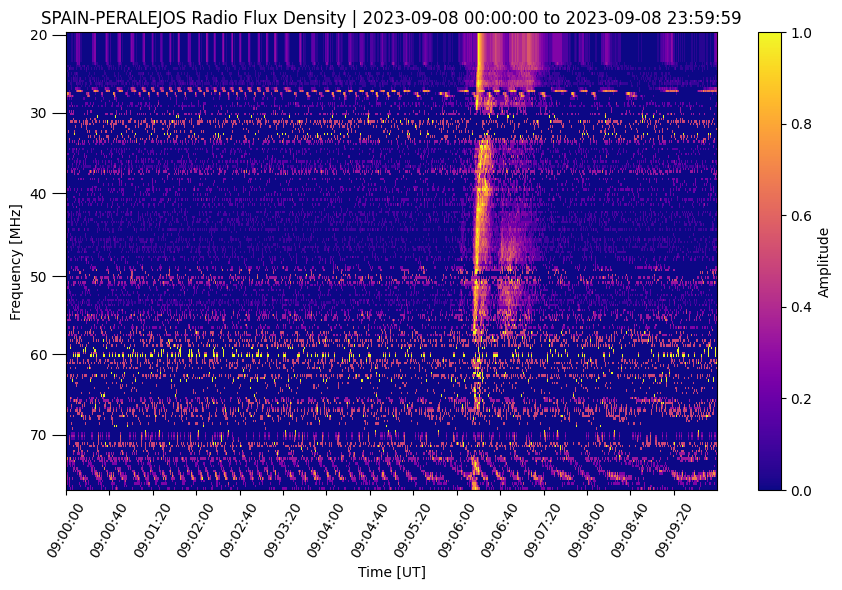

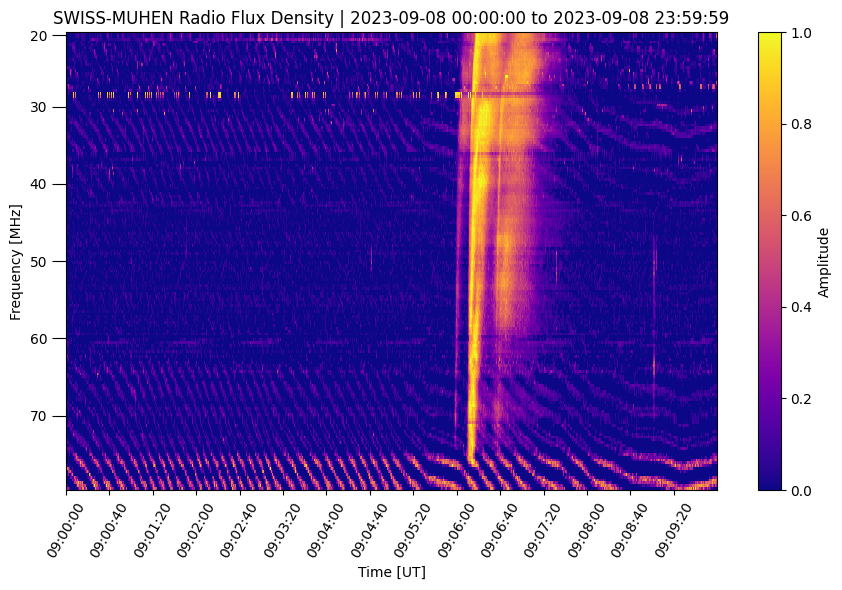

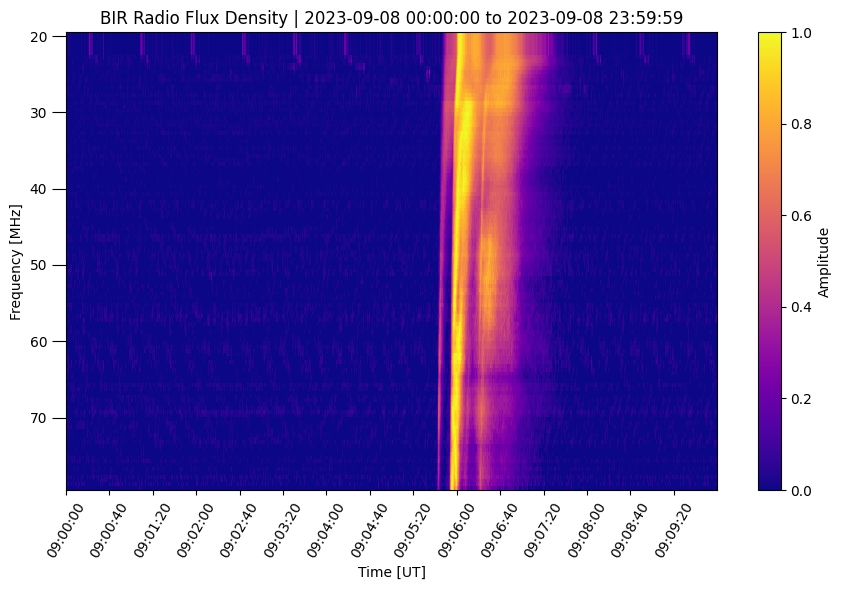

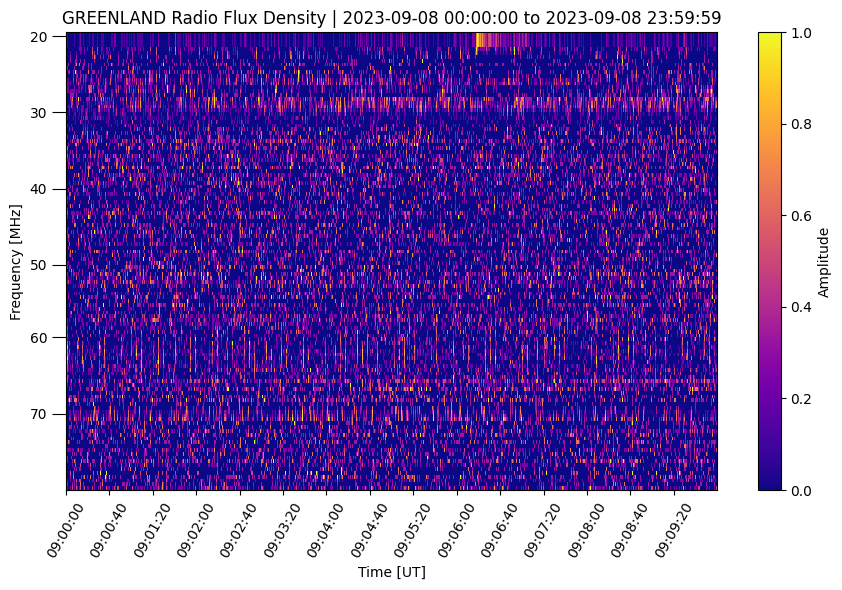

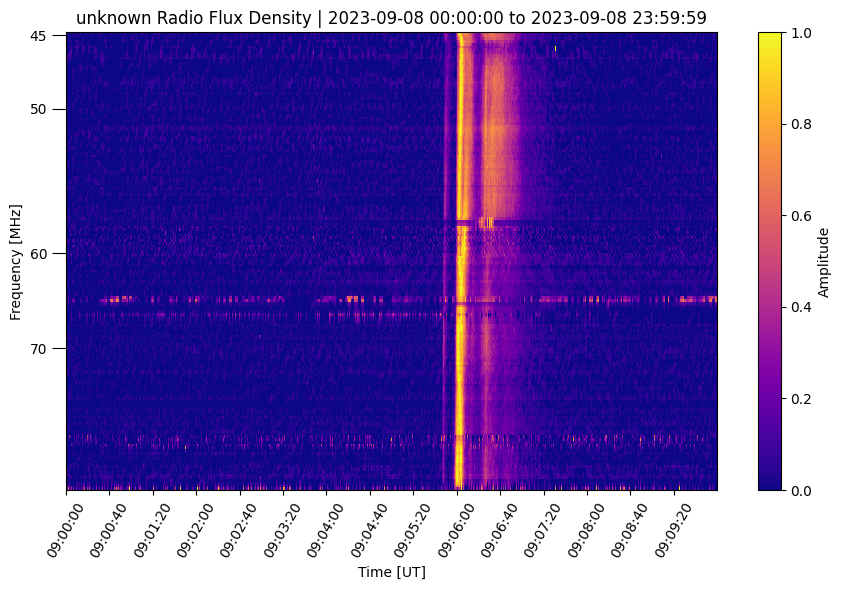

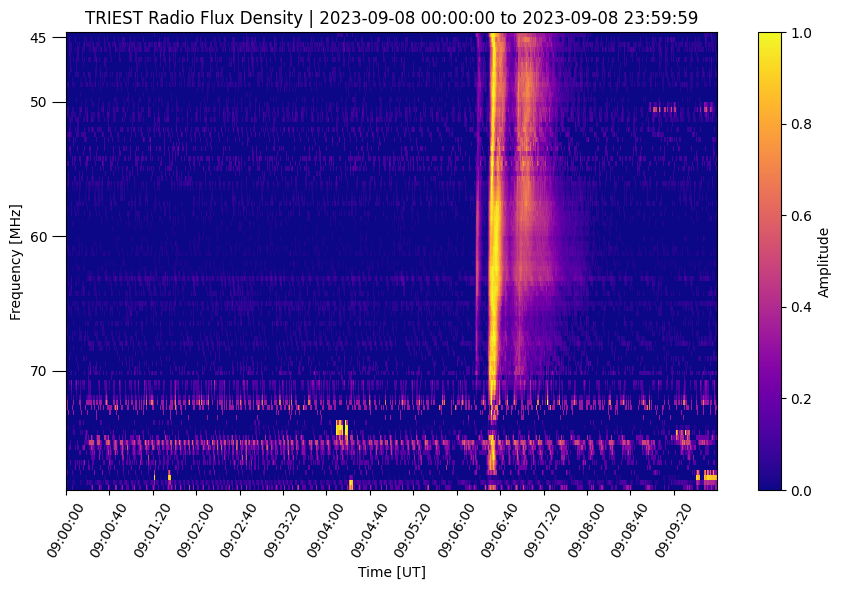

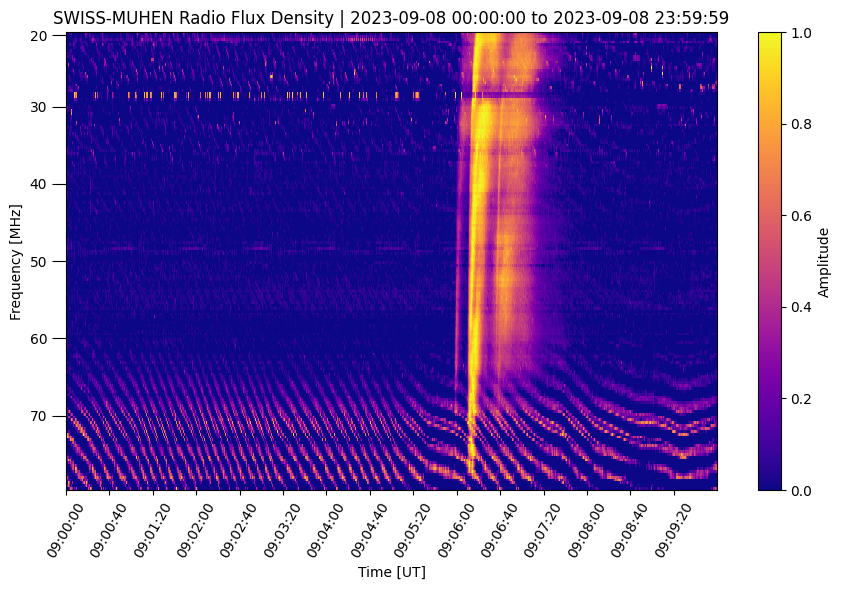

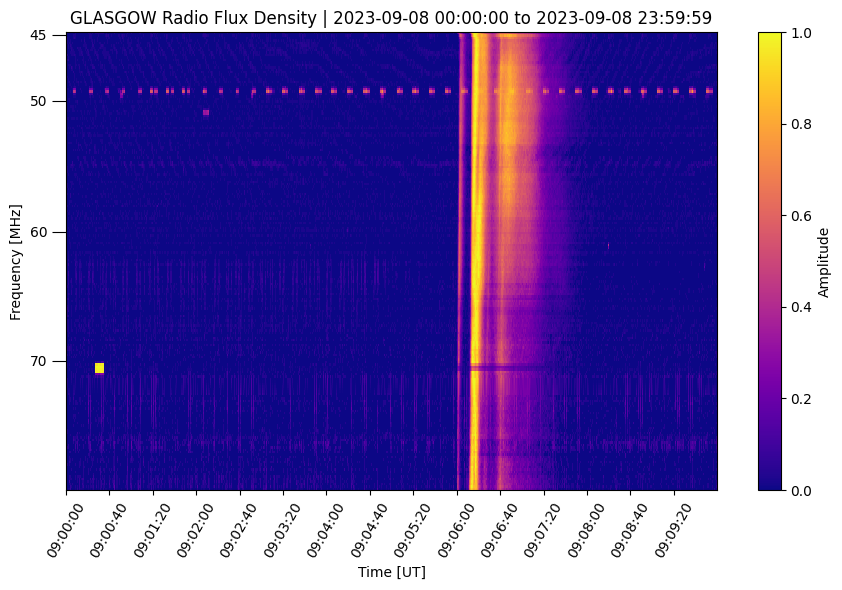

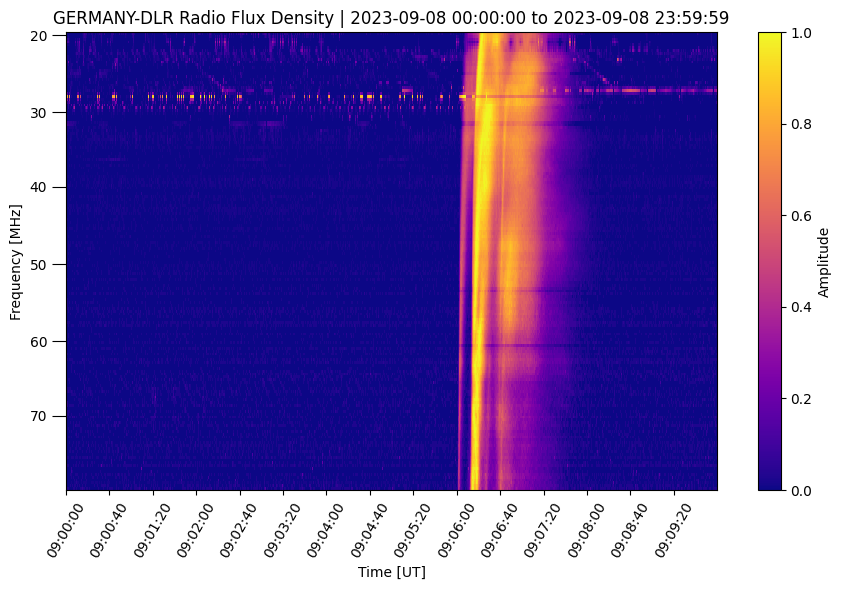

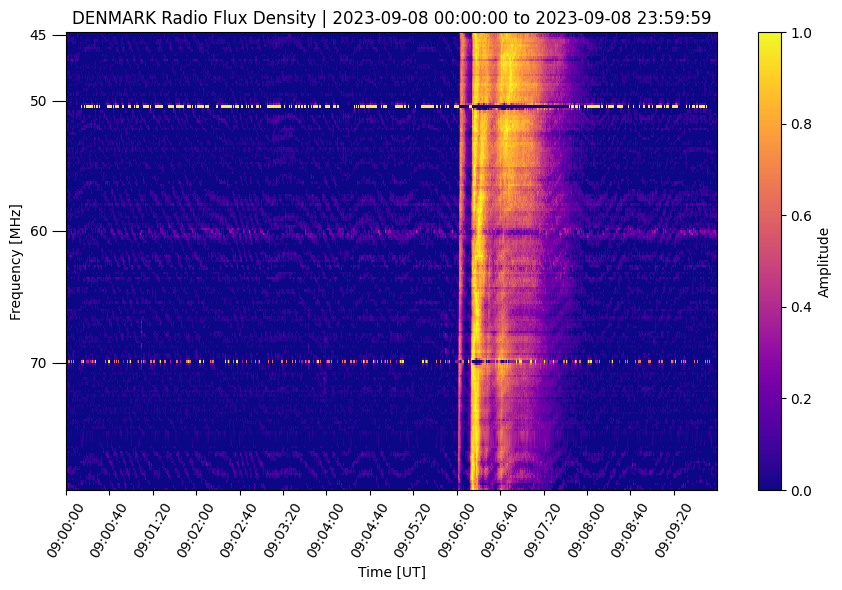

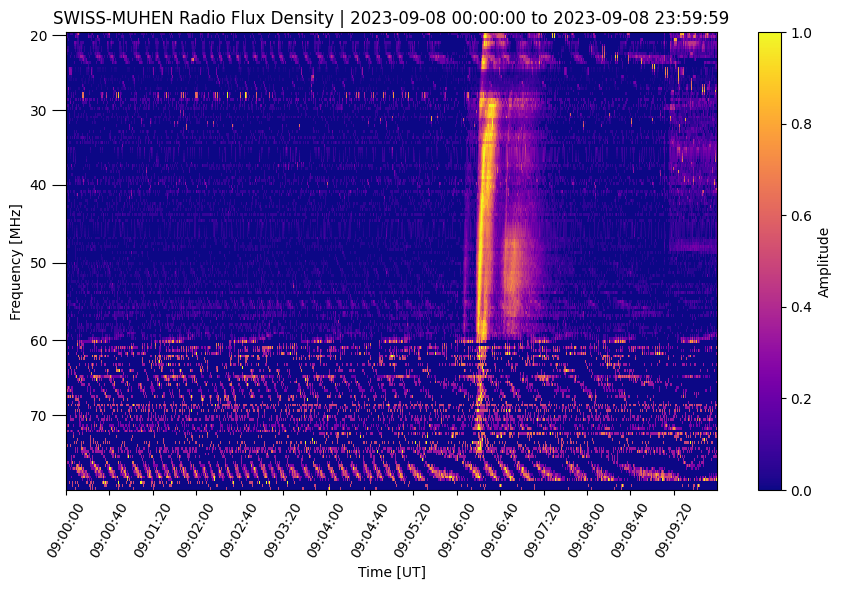

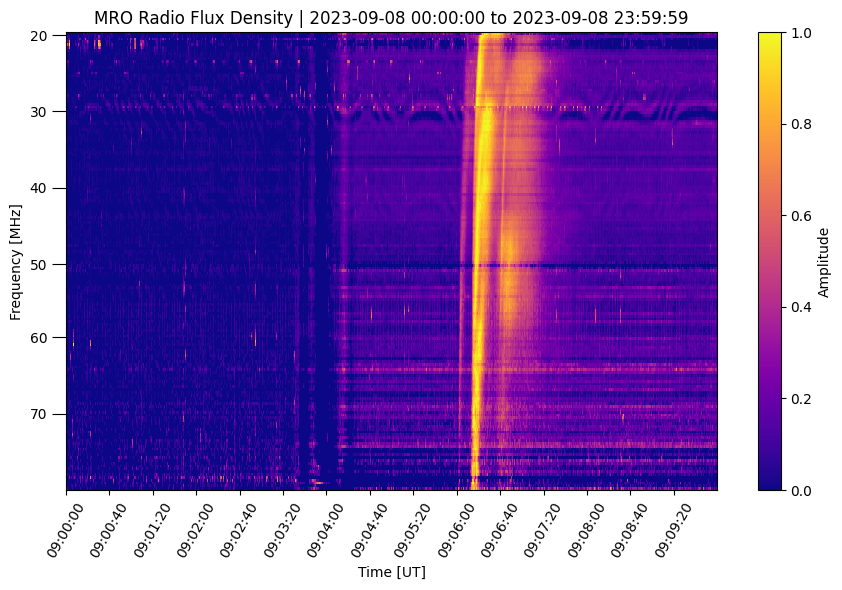

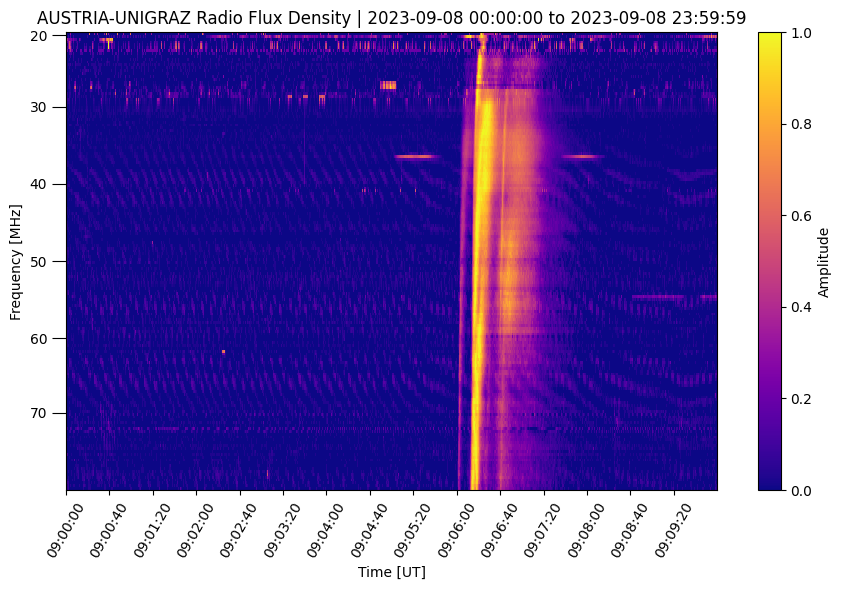

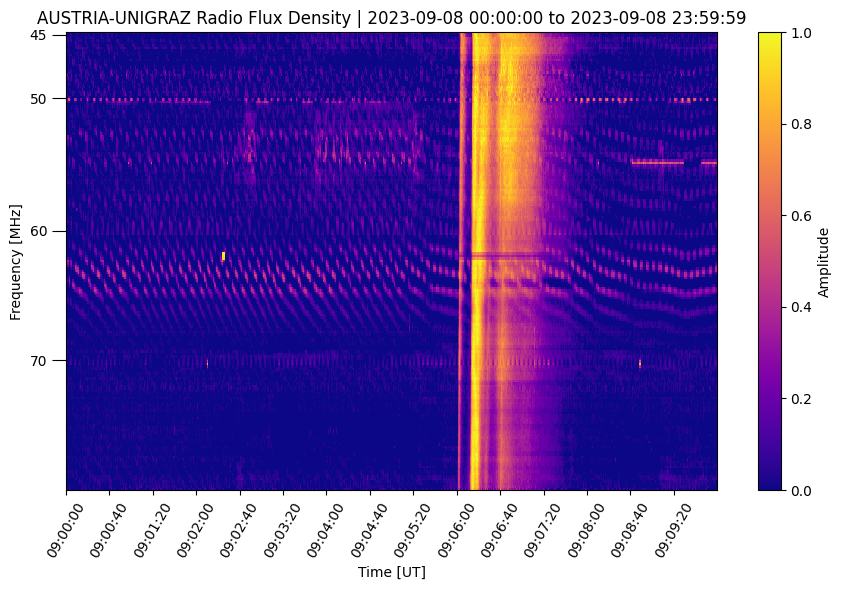

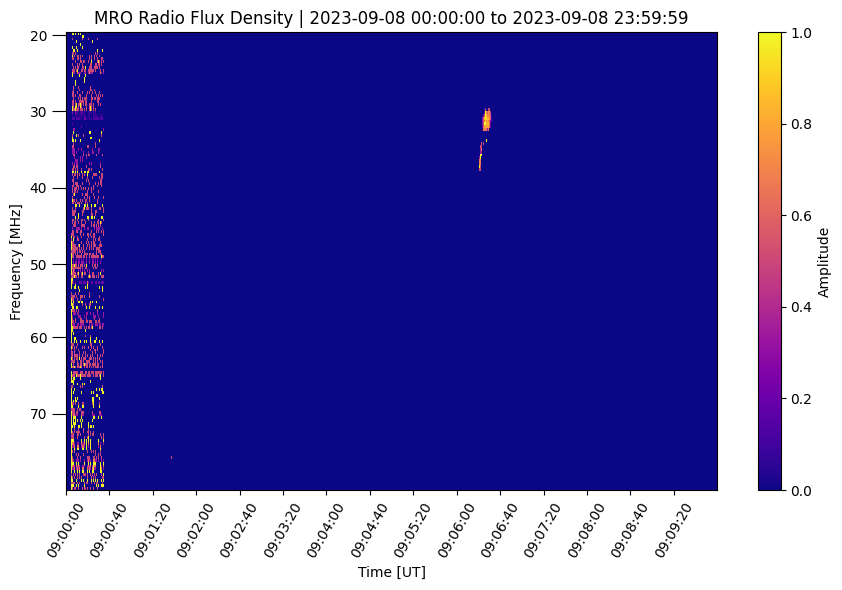

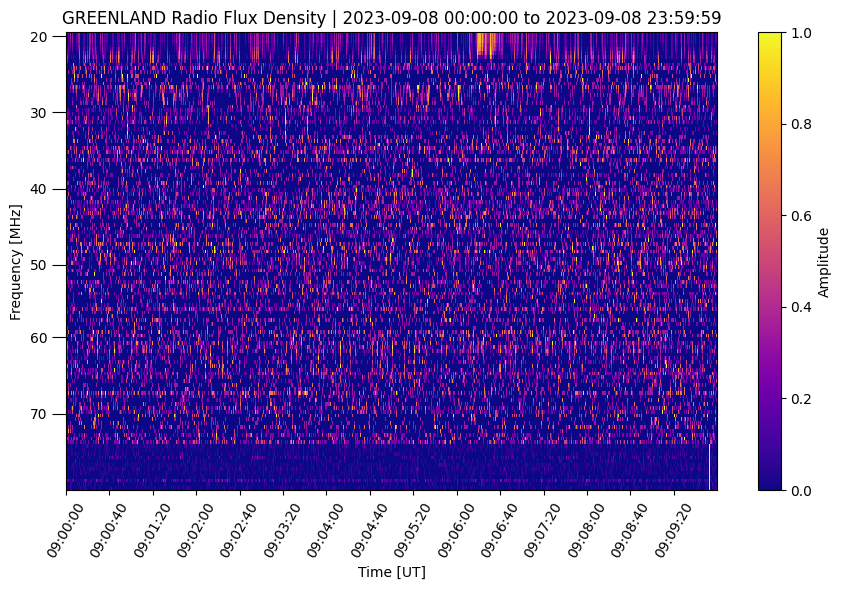

In [6]:
for data in data_processed:
    try:
        instr_name = data.attrs['INSTRUME']
    except:
        instr_name = 'unknown'
    fig = plot_spectogram_mpl(fill_missing_timesteps_with_nan(data), start_datetime=start_datetime, end_datetime=end_datetime, instrument_name=instr_name)

In [7]:
matched_data = match_spectrograms(data_processed)

/tmp/ipykernel_50831/1347820394.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()


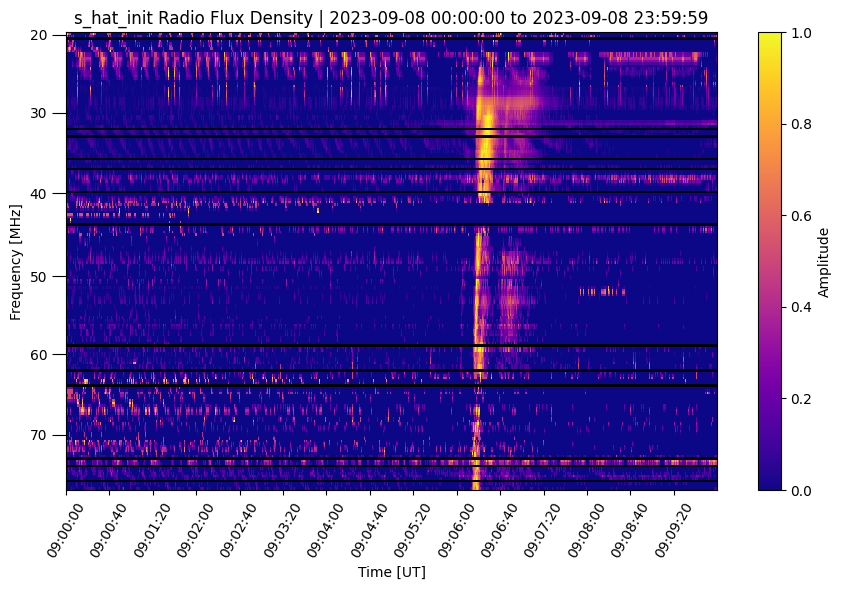

In [8]:
# plot
data_quantile_df = pd.DataFrame(matched_data[3], columns=data_processed[1].columns, index=data_processed[1].index)
plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()

In [9]:
synced_data, ref_idx = sync_spectrograms(matched_data)

/tmp/ipykernel_50831/2633502681.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()


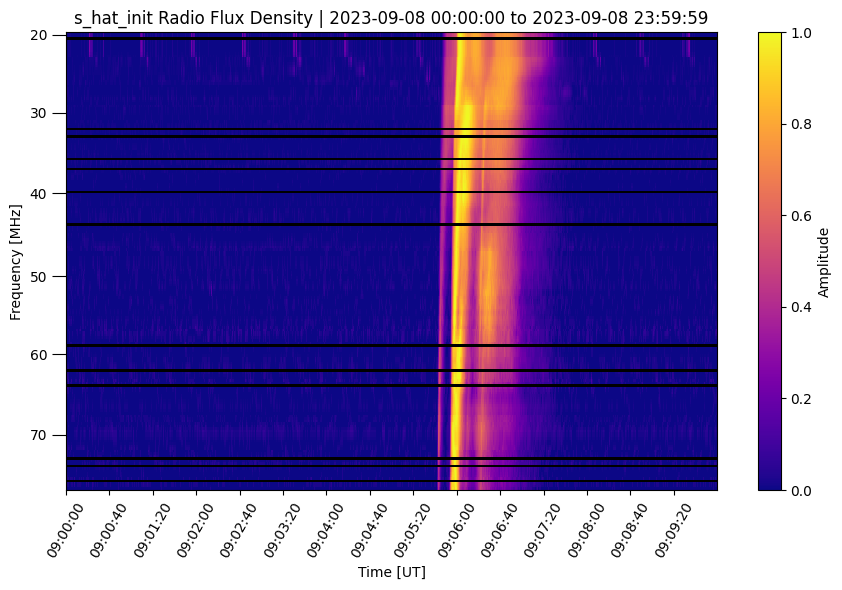

In [10]:
# plot
data_quantile_df = pd.DataFrame(synced_data[ref_idx], columns=data_processed[1].columns, index=data_processed[1].index)
plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()

/tmp/ipykernel_50831/699941292.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()


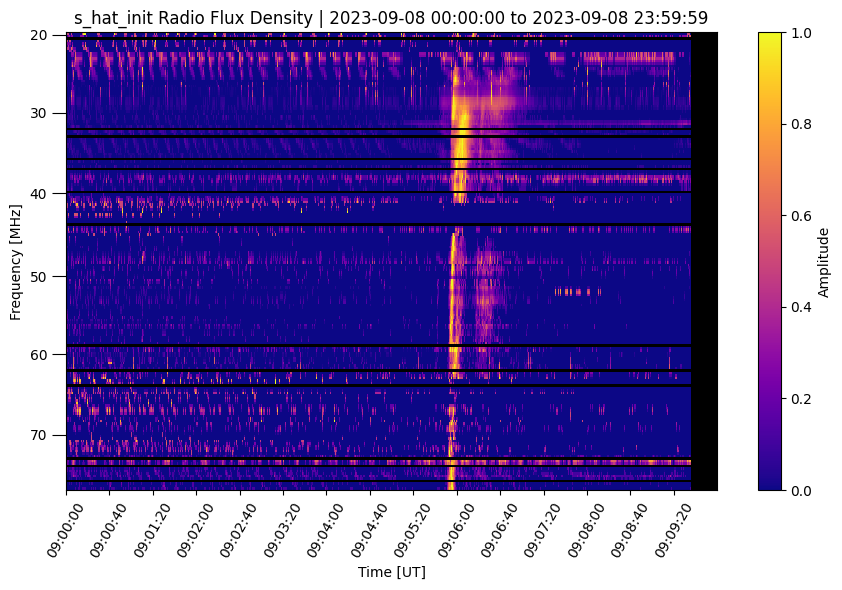

In [11]:
# plot
data_quantile_df = pd.DataFrame(synced_data[3].shift(-100), columns=data_processed[1].columns, index=data_processed[1].index)
plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()

In [12]:
# Correlation with reference spectogram
def correlation_with_reference(spec_list, ref_idx):
    ref_spec = np.sum(spec_list[ref_idx], axis=1)
    correlations = []
    for spec in spec_list:
        correlations.append(np.corrcoef(ref_spec, np.sum(spec, axis=1))[0, 1])
    return correlations

In [13]:
correlation_with_reference(synced_data, ref_idx)

[0.7448340569354003,
 0.7035469095609753,
 0.7288707569177326,
 0.5894732128069651,
 0.677026248511791,
 0.6255799410061313,
 0.7779676355440543,
 0.9999999999999999,
 0.0753697560988071,
 0.9041801272061255,
 0.49090647843618335,
 0.7776585247089077,
 0.7354567599451326,
 0.7414330314746587,
 0.74111679785412,
 0.656532014332832,
 0.7174710556673239,
 0.7388377313901773,
 0.7488570514770203,
 -0.05138740932794944,
 0.02757533848629498]

/tmp/ipykernel_50831/2790134524.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()


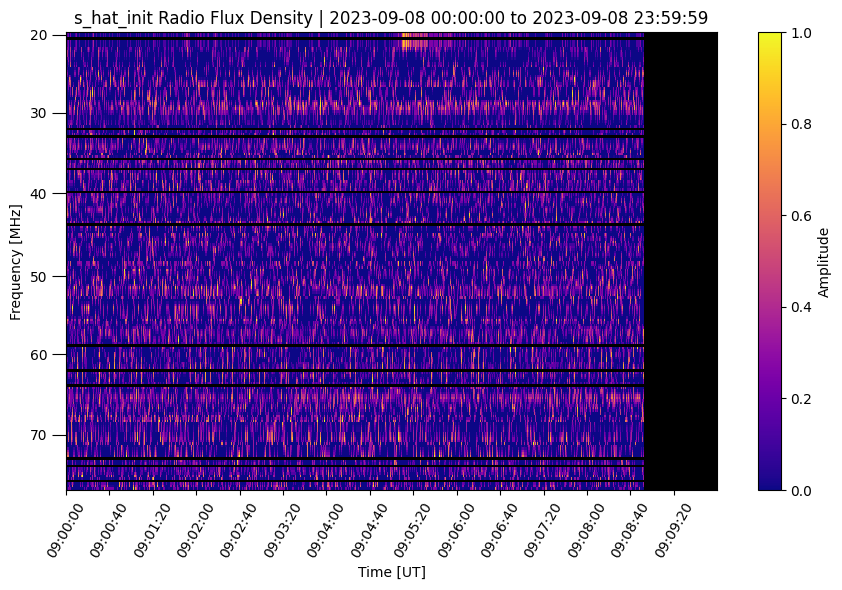

In [14]:
# plot
data_quantile_df = pd.DataFrame(synced_data[8], columns=data_processed[1].columns, index=data_processed[1].index)
plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()

In [15]:
torch_shifted = torch.stack([torch.from_numpy(df.values) for df in synced_data])
torch_quantile = torch.nanquantile(torch_shifted, 0.4, dim=0)

/tmp/ipykernel_50831/2389851722.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()


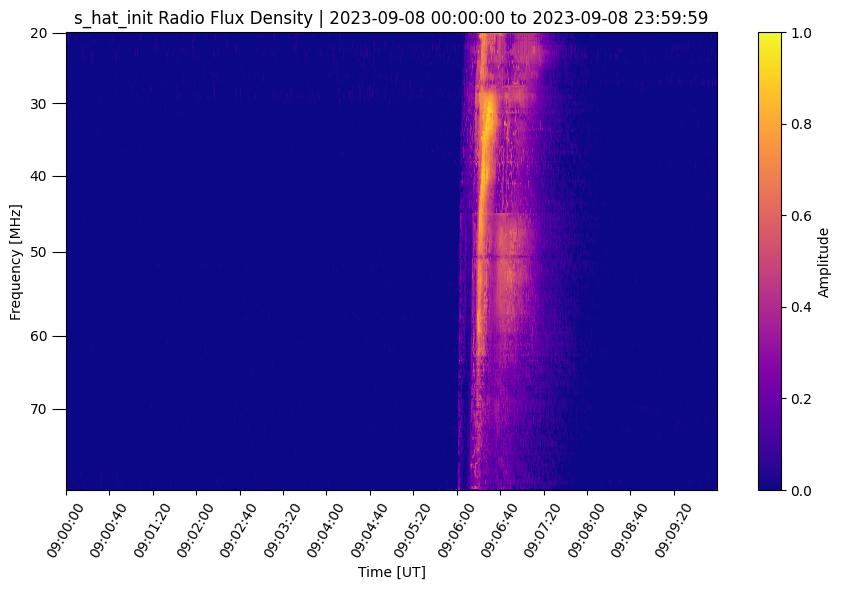

In [16]:
# plot
data_quantile_df = pd.DataFrame(torch_quantile, columns=matched_data[1].columns, index=matched_data[1].index)
plot_spectogram_mpl(data_quantile_df, 's_hat_init', start_datetime, end_datetime).show()

In [17]:
# Create for all quantiles 
torch_quantiles = []
for i in np.arange(0.1, 1.1, 0.1):
    torch_quantiles.append(torch.nanquantile(torch_shifted, i, dim=0))

In [18]:
from ipywidgets import interact
import pandas as pd

@interact(index=(0, len(torch_quantiles) - 1))
def plot_spectrogram(index=0):
    s_hat_df = pd.DataFrame(torch_quantiles[index], columns=data_processed[1].columns, index=data_processed[1].index)
    q = np.arange(0.1, 1.1, 0.1)[index]
    plot_spectogram_mpl(s_hat_df, f'E-Callisto virtual antenna, quantile: {q} |', start_datetime, end_datetime).show()


interactive(children=(IntSlider(value=0, description='index', max=9), Output()), _dom_classes=('widget-interac…